# Libraries

In [1]:
import re
import string
import csv
from joblib import dump, load

import numpy as np

import pandas as pd
#pd.set_option('display.max_colwidth', None)

import matplotlib.pyplot as plt
%matplotlib inline

import plotly.express as px

import nltk
from nltk import SnowballStemmer
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize
from nltk.stem import WordNetLemmatizer

from wordcloud import WordCloud

from sklearn import metrics
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import classification_report

# Loading data

In [2]:
df = pd.read_csv('../data/SMSSpamCollection.txt', sep=',\s+',quoting=csv.QUOTE_ALL, delimiter='\t', names= ['target','message'])

In [3]:
df['target'] = df['target'].apply(lambda row: row.strip())

#### Replace special characters (`&gt;` , `&lt;`, `<DECIMAL>`...)

In [4]:
special_chars = {
    "&quot;" : '"',
    "&apos;" : "'",
    "&amp;" : "&",
    "&lt;" : "<",
    "&gt;" : ">"
}
df = df.replace({'message': special_chars}, regex=True)

In [5]:
brackets = set()
def find_brackets(row):
    global brackets
    for bracket in re.findall(r'<[a-zA-Z0-9\s#]+>+', row):
        brackets.add(bracket)

df['message'].apply(find_brackets)
print(brackets)

{'<fone no>', '<EMAIL>', '<TIME>', '<Forwarded from 88877>', '<DECIMAL>', '<Forwarded from 21870000>', '<Forwarded from 448712404000>', '<UKP>', '<URL>', '<#>'}


In [6]:
special_chars = {
    "<DECIMAL>" : '123',
    "<UKP>" : "£",
    "<EMAIL>" : "abc@email.com",
    "<fone no>" : "<phone 0123456789>",
    "<URL>" : "https://www.abcd.com",
    "<#>" : "321",
    "<TIME>" : "13:00"
}
df = df.replace({'message': special_chars}, regex=True)

In [7]:
df.shape

(5574, 2)

- Our dataset contains 5574 observation and 2 characterisitics (which one is dependant variable, the other one is an independant variable)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5574 entries, 0 to 5573
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   target   5574 non-null   object
 1   message  5574 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


- The dataset consists of 5574 English messages, each entry is designated as being ham or spam. Dataframe has two columns: 
 - The first column `target` indicating the class of message as ham or spam.
 - The second column `message` is the content of the message.

In [9]:
df.sample(10, random_state=20)

target                                            message
283     ham                      Ok. I asked for money how far
1050   spam  18 days to Euro2004 kickoff! U will be kept in...
2297   spam  <Forwarded from 21870000>Hi - this is your Mai...
1385    ham  Storming msg: Wen u lift d phne, u say "HELLO"...
1446    ham                        I am in a marriage function
1510    ham  When u love someone Dont make them to love u a...
4784    ham  Especially since i talk about boston all up in...
1457    ham  U sleeping now.. Or you going to take? Haha.. ...
2671    ham  Yes. They replied my mail. I'm going to the ma...
5094    ham  My fri ah... Okie lor,goin 4 my drivin den go ...

In [10]:
df.groupby('target').describe()

message                                                               
         count unique                                                top freq
target                                                                       
ham       4827   4518                             Sorry, I'll call later   30
spam       747    653  Please call our customer service representativ...    4

- Our dataset contains 4518 (out of 4827) unique `ham` messages and 653 (out of 747) unique `spam` ones.
- `Sorry, I'll call later` is the most common `ham` message.
- `Please call our customer service representative on FREEPHONE...` is the most common `spam` message.


# Feature engineering

We will be adding the following columns to the dataframe:
- `word_count` : The number of words
- `sentence_count` : The number of sentences
- `brackets_count` : The number of text between brackets
- `links_count` : The number of links
- `phone_count` : The number of phone numbers
- `money_count` : The number of money amounts

In [11]:
class FeaturesExtractor(BaseEstimator, TransformerMixin):

    def __init__(self):
      nltk.download('punkt', quiet=True)
    
    def count_words(self, input_text):
        # remove punctuation, tokenize and return the number of tokens (words)
        message = input_text.translate(str.maketrans('', '', string.punctuation))
        return len(nltk.word_tokenize(input_text))

    def count_sentences(self, input_text):
        return len(sent_tokenize(input_text.lower()))

    def count_brackets(self, input_text):
        return len(re.findall(r'<[a-zA-Z0-9\s]+>+', input_text.lower()))

    def count_links(self, input_text):
        return len(re.findall(r'https?://\S+|www\.\S+', input_text.lower()))

    def count_phone(self, input_text):
        return len(re.findall(r'\d{5,}', input_text.lower()))

    def count_money(self, input_text):
        return len(re.findall(r'[$|£|€]\d+', input_text.lower()))+len(re.findall(r'\d+[$|£|€]', input_text.lower()))

    def transform(self, df, y=None):
        """The workhorse of this feature extractor"""
        df['word_count'] = df.message.apply(self.count_words)
        df['sentence_count'] = df.message.apply(self.count_sentences)
        df['brackets_count'] = df.message.apply(self.count_brackets)
        df['links_count'] = df.message.apply(self.count_links)
        df['phone_count'] = df.message.apply(self.count_phone)
        df['money_count'] = df.message.apply(self.count_money)
        return df
    def fit(self, df, y=None):
        """Returns `self` unless something different happens in train and test"""
        return self


In [12]:
tc = FeaturesExtractor()

df = tc.fit_transform(df)

df.sample(10, random_state=20)

target                                            message  word_count  \
283     ham                      Ok. I asked for money how far           8   
1050   spam  18 days to Euro2004 kickoff! U will be kept in...          28   
2297   spam  <Forwarded from 21870000>Hi - this is your Mai...          36   
1385    ham  Storming msg: Wen u lift d phne, u say "HELLO"...          99   
1446    ham                        I am in a marriage function           6   
1510    ham  When u love someone Dont make them to love u a...          36   
4784    ham  Especially since i talk about boston all up in...          32   
1457    ham  U sleeping now.. Or you going to take? Haha.. ...          25   
2671    ham  Yes. They replied my mail. I'm going to the ma...          26   
5094    ham  My fri ah... Okie lor,goin 4 my drivin den go ...          17   

      sentence_count  brackets_count  links_count  phone_count  money_count  
283                1               0            0            0            0  
1050               3               0            0            1            0  
2297               4               1            0            2            0  
1385              17               0            0            0            0  
1446               1               0            0            0            0  
1510               2               0            0            0            0  
4784               3               0            0            0            0  
1457               2               0            0            0            0  
2671               4               0            0            0            0  
5094               1               0            0            0            0

# EDA (Exploratory data analysis)

In [13]:
df.describe()

word_count  sentence_count  brackets_count  links_count  phone_count  \
count  5574.000000     5574.000000     5574.000000  5574.000000  5574.000000   
mean     18.466990        1.916039        0.000897     0.019914     0.136706   
std      13.236109        1.439036        0.029940     0.139717     0.436087   
min       1.000000        1.000000        0.000000     0.000000     0.000000   
25%       9.000000        1.000000        0.000000     0.000000     0.000000   
50%      15.000000        1.000000        0.000000     0.000000     0.000000   
75%      27.000000        2.000000        0.000000     0.000000     0.000000   
max     196.000000       34.000000        1.000000     1.000000     3.000000   

       money_count  
count  5574.000000  
mean      0.061715  
std       0.294324  
min       0.000000  
25%       0.000000  
50%       0.000000  
75%       0.000000  
max       3.000000

- The average number of words is (`mean`) 18 word
- The average number of sentences is (`mean`) 2 sentences
- The mean values are close to medians
- There's a large difference  between the 75% and max value (there might be outliers in the dataset)

- The longest message (in terms of `word_count`) contains 196 (`max`) word

In [14]:
df.loc[df['word_count'] == df['word_count'].max()]

target                                            message  word_count  \
1863    ham  The last thing i ever wanted to do was hurt yo...         196   

      sentence_count  brackets_count  links_count  phone_count  money_count  
1863              10               0            0            0            0

- The shortest message contains 1 word

In [15]:
df.loc[df['word_count'] < 2].sort_values('word_count').head(5)

target message  word_count  sentence_count  brackets_count  links_count  \
261     ham     Yup           1               1               0            0   
1612    ham     645           1               1               0            0   
1925    ham      Ok           1               1               0            0   
2602    ham    Okie           1               1               0            0   
2688    ham    Okie           1               1               0            0   

      phone_count  money_count  
261             0            0  
1612            0            0  
1925            0            0  
2602            0            0  
2688            0            0

## Detecting outliers using the 1.5 IQR (Interquartile Rule)

### Applying the 1.5 IQ rule to `word_count`
- IQR = Q3-Q1 = 16 | Q1 = 7 | Q3 = 23
- IQR * 1.5 = 24
- IQR * 1.5 - Q1 = 17
- Q3 + IQR * 1.5 = 47

In [16]:
wc_desc = df.describe()['word_count']
wc_Q1, wc_Q3 = wc_desc['25%'], wc_desc['75%']
IQR = wc_Q3 - wc_Q1
low, high = IQR * 1.5 - wc_Q1 , wc_Q3 + IQR * 1.5
print(f'Low outliers count : {len(df[df.word_count<low])}\nHigh outliers count : {len(df[df.word_count>high])}')

Low outliers count : 3227
High outliers count : 71


- Removing low outliers will result in removing more than **half** of the data, while high outliers count is low so it will not affect our data.

### Applying the 1.5 IQ rule to `sentence_count`
- IQR = Q3-Q1 = 16 | Q1 = 7 | Q3 = 23
- IQR * 1.5 = 24
- IQR * 1.5 - Q1 = 17
- Q3 + IQR * 1.5 = 47

In [17]:
wc_desc = df.describe()['sentence_count']
wc_Q1, wc_Q3 = wc_desc['25%'], wc_desc['75%']
IQR = wc_Q3 - wc_Q1
low, high = IQR * 1.5 - wc_Q1 , wc_Q3 + IQR * 1.5
print(f'Low outliers count : {len(df[df.sentence_count<low])}\nHigh outliers count : {len(df[df.sentence_count>high])}')

Low outliers count : 0
High outliers count : 608


- There are no lower outliers in the dataset, while there're 662 high outliers. Like `word_count`, high outliers count is low so they will not affect the data.

### Pairplot of the dataset

In [18]:
fig = px.scatter_matrix(df,
                        dimensions=df.drop(['target','message'],axis=1).columns,
                        color="target",
                        height=700)
fig.show()

## Count of every class

In [19]:
counts = df.groupby('target').count().reset_index()
counts = counts.rename(columns = {"message":"count"})
fig = px.bar(counts,
             x='target',
             y='count',
             color='target',
             width = 500, height=400)
fig.update_layout(title_text='Count of ham and spam messages in the dataset',
                  xaxis_title_text='Class',
                  yaxis_title_text='Count')
fig.show()

- The dataset contains **4827** `ham` message, and **747** `spam` ones
- The dataset is imbalanced

## Word count distribution

In [20]:
fig_hist = px.histogram(df,
                        x="word_count",
                        color="target",
                        barmode="overlay",
                        marginal="violin", #box or rug
                        hover_data=df.columns,
                        range_x=["0","100"],
                        width=700)
fig_hist.update_layout(title_text='Message length distribution (Word count)',
                       xaxis_title_text='Word Count',
                       bargap=0.3)
fig_hist.show()

- As we can see, `ham` message lenght tends to be lower than `spam` message lenght.

## Sentence count distribution

In [21]:
fig_hist = px.histogram(df,
                        x="sentence_count",
                        color="target",
                        barmode="overlay",
                        marginal="violin", #box or rug
                        hover_data=df.columns,
                        range_x=["0","40"],
                        width=700)
fig_hist.update_layout(title_text='Message length distribution (Sentence count)',
                       xaxis_title_text='Sentence Count',
                       bargap=0.3)
fig_hist.show()

## Other features count distribution

## Data pre-processing

In [22]:
class ColumnExtractor(TransformerMixin, BaseEstimator):
    def __init__(self, cols):
        self.cols = cols

    def transform(self, X, **transform_params):        
        return X[self.cols]

    def fit(self, X, y=None, **fit_params):
        return self

### Text cleaning

Before we start using the messages we clean them. We'll do the this in the class CleanText:

    - Set all words to lowercase
	- Replace text between brackets with 'bracketstext' (present in spam messages)
	- Replace money amounts ($123 or 1£) with 'moneytext'
	- Replace remaining currency symbols with 'currsymb'
	- Replace links with 'weblink'
	- Replace phone numbers with 'phonenumber'
	- Replace emojis with their code
	- Replace punctuation with whitespace
	- Remove extra whitespaces
    - Remove remaining digits
    - Remove stopwords
    - Apply SnowballStemmer to keep the stem of words
    - (Optional) Lemmatize the text using WordNetLemmatizer


In [23]:
class CleanText(BaseEstimator, TransformerMixin):

	def __init__(self):
		nltk.download('stopwords', quiet=True)
		nltk.download('wordnet', quiet=True)
	
	def to_lower(self, input_text):
		return input_text.lower()

	def replace_brackets(self, input_text):
		# Replace text between brackets with 'bracketstext' (spam messages)
		return re.sub('<.*?>+', ' bracketstext ', input_text)

	def replace_money(self, input_text):
		# Replace money amounts ($123 or 1£) with 'moneytext'
		input_text = re.sub(r'[$|£|€]\d+', ' moneytext ', input_text)
		return re.sub(r'\d+[$|£|€]', ' moneytext ', input_text)

	def replace_currency(self, input_text):
		# Replace remaining currency symbols with 'currsymb'
		return re.sub(r'[$|£|€]', ' currsymb ', input_text)

	def replace_urls(self, input_text):
		# Replace links with 'weblink'
		link_regex = r'(http(s)?:\/\/.)?(www\.)?[-a-zA-Z0-9@:%._\+~#=]{2,256}\.[a-z]{2,6}\b([-a-zA-Z0-9@:%_\+.~#?&//=]*)'
		link_regex1 = r'https?://\S+|www\.\S+'
		link_regex2 = r'http.?://[^\s]+[\s]?'
		return re.sub(link_regex1, ' weblink ', input_text)

	def replace_phone_numbers(self, input_text):
		# Replace phone numbers with 'phonenumber'
		return re.sub(r'\d{5,}', ' phonenumber ', input_text)

	def replace_emojis(self, input_text):
		# TODO :Replace emojis with their code
		pass

	def replace_punctuation(self, input_text):
		# Replace punctuation with a space
		return input_text.translate(str.maketrans(dict.fromkeys(list(string.punctuation),' ')))
	
	def remove_extra_whitespace(self, input_text):
		# Remove extra whitespaces
		return re.sub(r'\s+', ' ', input_text)

	def remove_digits(self, input_text):
		return re.sub('\d+', '', input_text)

	def remove_stopwords(self, input_text):
		stop_words = stopwords.words('english')

		words = input_text.split()
		clean_words = [word for word in words if word not in stop_words]
		return ' '.join(clean_words)

	def apply_stemming(self, input_text):
		stemmer = SnowballStemmer('english')
		
		words = input_text.split()
		stemmed_words = [stemmer.stem(word) for word in words]
		return ' '.join(stemmed_words)

	def apply_lemmatization(self, input_text):
		lemmatizer = WordNetLemmatizer()

		words = input_text.split()
		lemmatized_words = [lemmatizer.lemmatize(word, pos="v") for word in words]
		return ' '.join(lemmatized_words)


	def fit(self, X, y=None, **fit_params):
		return self

	def transform(self, X, **transform_params):
		clean_X = X.apply(self.to_lower)
		clean_X = clean_X.apply(self.replace_brackets)
		clean_X = clean_X.apply(self.replace_money)
		clean_X = clean_X.apply(self.replace_currency)
		clean_X = clean_X.apply(self.replace_urls)
		clean_X = clean_X.apply(self.replace_phone_numbers)
		# clean_X = clean_X.apply(self.replace_emojis)
		clean_X = clean_X.apply(self.replace_punctuation)
		clean_X = clean_X.apply(self.remove_extra_whitespace)
		clean_X = clean_X.apply(self.remove_digits)
		clean_X = clean_X.apply(self.remove_stopwords)
		clean_X = clean_X.apply(self.apply_stemming)
		return clean_X

One side-effect of text cleaning is that some rows do not have any words left in their text. To deal with these missing values, we impute them with some placeholder text like `no_text`.

In [24]:
ct = CleanText()

clean_msg = ct.fit_transform(df.message)
empty = clean_msg == ''
print(f'{clean_msg[empty].count()} records have no words left after text cleaning')
clean_msg.loc[empty] = 'no_text'

df['message_clean'] = clean_msg

8 records have no words left after text cleaning


### Target Encoding (spam = 1 / ham = 0)

In [25]:
encoder = LabelEncoder()
targets = encoder.fit_transform(df.target)

df['target_encoded'] = targets

### Count of spam messages containing phone numbers, weblinks and money

In [26]:
num_phone = len(df.query("phone_count!=0 and target_encoded==1"))
num_link = len(df.query("links_count!=0 and target_encoded==1"))
num_money = len(df.query("money_count!=0 and target_encoded==1"))
num_brackets = len(df.query("brackets_count!=0 and target_encoded==1"))

print(f'There are {num_phone} rows containing phone numbers, {num_link} ones containing links, {num_money} ones containing money, and {num_brackets} ones containing brackets.')
print(f'out of {len(df[df.target_encoded==1])} spam message')

There are 585 rows containing phone numbers, 106 ones containing links, 256 ones containing money, and 5 ones containing brackets.
out of 747 spam message


## Tokens Visualization

### Top words in ham messages

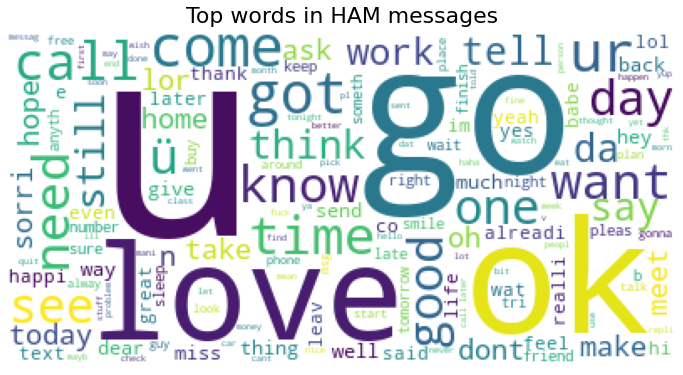

In [27]:
wc = WordCloud(background_color='white', max_words=150)
wc.generate(' '.join(df['message_clean'][df['target']=='ham']))
plt.figure(figsize=(12, 8))
plt.title('Top words in HAM messages',fontdict={'size': 22,  'verticalalignment': 'bottom'})
plt.imshow(wc)
plt.axis('off')
plt.show()

### Top words in spam messages

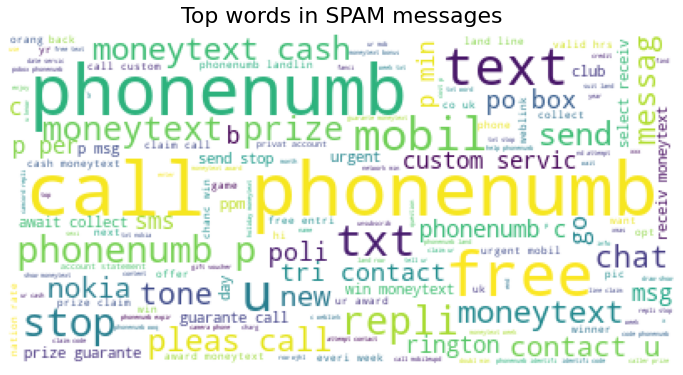

In [28]:
wc = WordCloud(background_color='white', max_words=150)
wc.generate(' '.join(df['message_clean'][df['target']=='spam']))
plt.figure(figsize=(12, 8))
plt.title('Top words in SPAM messages',fontdict={'size': 22,  'verticalalignment': 'bottom'})
plt.imshow(wc)
plt.axis('off')
plt.show()

- As we can notice, phone numbers and money amounts are mostly used in spam messages

## Splitting data into train and test

In [29]:
X, y = df.drop(['target_encoded','target'], axis=1), df.target_encoded

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=37)

print('Train shapes:', X_train.shape, y_train.shape,'\nTest shapes:', X_test.shape, y_test.shape)

Train shapes: (5016, 8) (5016,) 
Test shapes: (558, 8) (558,)


## Vectorization

In [30]:
textcountscols = ['word_count', 'sentence_count', 'brackets_count', 'links_count', 'phone_count', 'money_count']    

def grid_vect(clf, clf_params, X_train, y_train, X_test, y_test, parameters_text=None, vectorizer=None, cv_nb=5):
    vect_pipe = Pipeline([
        ('cleantext', ColumnExtractor(cols='message_clean')),
        ('vect', vectorizer)
    ])

    col_ext = ColumnExtractor(cols=textcountscols)
    features = FeatureUnion([('textcounts', col_ext), ('pipe', vect_pipe)], n_jobs=1)
    
    pipeline = Pipeline([('features', features), ('clf', clf)])

    # Join both parameters dictionaries together
    parameters = dict()
    if parameters_text:
        parameters.update(parameters_text)
    parameters.update(clf_params)
    
    grid_search = GridSearchCV(pipeline, parameters, scoring='f1', n_jobs=-1, verbose=1, cv=cv_nb)
    
    print("Performing Grid Search...")
    grid_search.fit(X_train, y_train)
    print("Grid Search Results :")
    print(f"Best CV score: {grid_search.best_score_}")
    print("Best parameters :")

    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print(f"\t{param_name}: {best_parameters[param_name]}")

    GS_best_estimator = grid_search.best_estimator_
    print(f"Train score with best_estimator_: {GS_best_estimator.score(X_train, y_train):.3f}")
    print(f"Test score with best_estimator_: {GS_best_estimator.score(X_test, y_test):.3f}")

    print("Classification Report Test Data")
    print(classification_report(y_test, GS_best_estimator.predict(X_test), target_names=['ham','spam']))
    
    return grid_search

In [31]:
# Parameter grid settings for the vectorizers
parameters_vect = {
    'features__pipe__vect__max_df': (0.25, 0.5, 0.75),
    'features__pipe__vect__ngram_range': ((1, 1), (1, 2)),
    'features__pipe__vect__min_df': (1, 2, 3)
}


# Parameter grid settings for MultinomialNB
parameters_mnb = {
    'clf__alpha': (0.00001, 0.0001, 0.001, 0.01, 0.1, 0.2, 0.25, 0.3, 0.4, 0.5, 0.75, 0.8, 0.9, 1.0)
}


# Parameter grid settings for KNN
parameters_knn = {
    'clf__n_neighbors': (3, 5, 7, 8, 9, 10, 25, 30, 50, 70, 74)
}

## Classifiers

In [32]:
mnb = MultinomialNB()
knn = KNeighborsClassifier()

### CountVectorizer

In [33]:
c_vect = CountVectorizer()

In [34]:
# MultinomialNB x CountVectorizer
mnb_countvect = grid_vect(mnb, parameters_mnb, X_train, y_train, X_test, y_test, parameters_text=parameters_vect, vectorizer=c_vect)

Performing Grid Search...
Fitting 5 folds for each of 252 candidates, totalling 1260 fits
Grid Search Results :
Best CV score: 0.9629956006482884
Best parameters :
	clf__alpha: 0.3
	features__pipe__vect__max_df: 0.25
	features__pipe__vect__min_df: 1
	features__pipe__vect__ngram_range: (1, 2)
Train score with best_estimator_: 0.999
Test score with best_estimator_: 0.984
Classification Report Test Data
              precision    recall  f1-score   support

         ham       0.98      1.00      0.99       473
        spam       0.99      0.91      0.94        85

    accuracy                           0.98       558
   macro avg       0.99      0.95      0.97       558
weighted avg       0.98      0.98      0.98       558



In [35]:
# KNN x CountVectorizer
knn_countvect = grid_vect(knn, parameters_knn, X_train, y_train, X_test, y_test, parameters_text=parameters_vect, vectorizer=c_vect)

Performing Grid Search...
Fitting 5 folds for each of 198 candidates, totalling 990 fits
Grid Search Results :
Best CV score: 0.834793573904788
Best parameters :
	clf__n_neighbors: 3
	features__pipe__vect__max_df: 0.25
	features__pipe__vect__min_df: 3
	features__pipe__vect__ngram_range: (1, 1)
Train score with best_estimator_: 0.976
Test score with best_estimator_: 0.961
Classification Report Test Data
              precision    recall  f1-score   support

         ham       0.96      1.00      0.98       473
        spam       1.00      0.74      0.85        85

    accuracy                           0.96       558
   macro avg       0.98      0.87      0.91       558
weighted avg       0.96      0.96      0.96       558



### TF-IDF

In [36]:
tfidf_vect = TfidfVectorizer()

In [37]:
# MultinomialNB x TF-IDF
mnb_tfidf = grid_vect(mnb, parameters_mnb, X_train, y_train, X_test, y_test, parameters_text=parameters_vect, vectorizer=tfidf_vect)

Performing Grid Search...
Fitting 5 folds for each of 252 candidates, totalling 1260 fits
Grid Search Results :
Best CV score: 0.9529074057909013
Best parameters :
	clf__alpha: 0.01
	features__pipe__vect__max_df: 0.25
	features__pipe__vect__min_df: 1
	features__pipe__vect__ngram_range: (1, 2)
Train score with best_estimator_: 1.000
Test score with best_estimator_: 0.984
Classification Report Test Data
              precision    recall  f1-score   support

         ham       0.99      1.00      0.99       473
        spam       0.97      0.92      0.95        85

    accuracy                           0.98       558
   macro avg       0.98      0.96      0.97       558
weighted avg       0.98      0.98      0.98       558



In [38]:
# KNN x TF-IDF
knn_tfidf = grid_vect(knn, parameters_knn, X_train, y_train, X_test, y_test, parameters_text=parameters_vect, vectorizer=tfidf_vect)

Performing Grid Search...
Fitting 5 folds for each of 198 candidates, totalling 990 fits
Grid Search Results :
Best CV score: 0.8677334475932774
Best parameters :
	clf__n_neighbors: 3
	features__pipe__vect__max_df: 0.25
	features__pipe__vect__min_df: 3
	features__pipe__vect__ngram_range: (1, 2)
Train score with best_estimator_: 0.981
Test score with best_estimator_: 0.959
Classification Report Test Data
              precision    recall  f1-score   support

         ham       0.96      1.00      0.98       473
        spam       0.97      0.75      0.85        85

    accuracy                           0.96       558
   macro avg       0.96      0.87      0.91       558
weighted avg       0.96      0.96      0.96       558



## Best model

In [39]:
textcountscols = ['word_count', 'sentence_count', 'brackets_count', 'links_count', 'phone_count', 'money_count']    

vectorizer = CountVectorizer(max_df=0.25, min_df=1, ngram_range=(1,2))
clf_mnb = MultinomialNB(alpha=0.3) 

vect_pipe = Pipeline([('cleantext', ColumnExtractor(cols='message_clean')),('vect', vectorizer)])
col_ext = ColumnExtractor(cols=textcountscols)

features = FeatureUnion([('textcounts', col_ext), ('pipe', vect_pipe)], n_jobs=-1)
pipeline = Pipeline([('features', features), ('clf', clf_mnb)])

best_model = pipeline.fit(X_train, y_train)

In [40]:
model_path = '../model/model.joblib'
dump(best_model, model_path)

['../model/model.joblib']

In [41]:
recall = cross_val_score(best_model, X_test, y_test, cv=10, scoring='recall')
print(f'Recall : Mean = {np.mean(recall)}')
print(recall)

print('-'*10)

precision = cross_val_score(best_model, X_test, y_test, cv=10, scoring='precision')
print(f'Precision : Mean = {np.mean(precision)}')
print(precision)

print('-'*10)

f1 = cross_val_score(best_model, X_test, y_test, cv=10, scoring='f1')
print(f'f1 : Mean = {np.mean(f1)}')
print(f1)


Recall : Mean = 0.8597222222222222
[1.         0.75       0.875      0.88888889 0.77777778 0.88888889
 0.77777778 0.88888889 0.875      0.875     ]
----------
Precision : Mean = 0.9875
[1.    1.    1.    1.    1.    1.    1.    1.    1.    0.875]
----------
f1 : Mean = 0.9172338935574229
[1.         0.85714286 0.93333333 0.94117647 0.875      0.94117647
 0.875      0.94117647 0.93333333 0.875     ]


In [42]:
def predict(model_path, data):
    df = pd.DataFrame(data, columns=['message'])
    tc = FeaturesExtractor()
    ct = CleanText()

    df_counts = tc.transform(df)
    df_clean = ct.transform(df.message)
    df = df_counts
    df['message_clean'] = df_clean
    
    model = load(model_path)
    predictions = model.predict(df).tolist()
    predictions = [ ['ham','spam'][prediction] for prediction in predictions]
    print('Model predictions:')
    for i in range(len(data)):
        print(f'{data[i]} : {predictions[i]}')


In [43]:
my_msg = ["Hello, can you please call me later ?",
          "Lets meet 2morroww after class",
          "Congratulations! You've won a $1OOO Walmart gift card. Go to http://bit.ly/123456to claim now.",
          "Take 20% off your order with code THANKYOU."]

predict(model_path, my_msg)

Model predictions:
Hello, can you please call me later ? : ham
Lets meet 2morroww after class : ham
Congratulations! You've won a $1OOO Walmart gift card. Go to http://bit.ly/123456to claim now. : spam
Take 20% off your order with code THANKYOU. : ham
